***Preprocessing***

***- Import Library***

In [ ]:
## Remove Warnings
import warnings
warnings.filterwarnings('ignore')
## Data
import pandas as pd
import numpy as np
import math

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.cm as cm

## Preprocessing
from sklearn.preprocessing import MinMaxScaler

## Cluster Modelling
from scipy import stats
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [ ]:
# Load dataset
df = pd.read_csv('./customer_shopping_segmentation.csv')

df.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [ ]:
df.describe()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,1.000010e+08,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,5.774946e+02,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,1.000000e+08,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,1.000005e+08,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,1.000010e+08,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000015e+08,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000020e+08,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


In [ ]:
# Since we don't need the ID. So, I decided to drop this column.
df.drop('ID', axis=1, inplace=True)
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,67,2,124670,1,2
1,1,1,22,1,150773,1,2
2,0,0,49,1,89210,0,0
3,0,0,45,1,171565,1,1
4,0,0,53,1,149031,1,1


In [ ]:
def decode_df(temp_df):
    temp_df = temp_df.copy()
    temp_df['Sex'] = temp_df['Sex'].replace(0, 'Male')
    temp_df['Sex'] = temp_df['Sex'].replace(1, 'Female')
    temp_df['Marital status'] = temp_df['Marital status'].replace(0, 'Single')
    temp_df['Marital status'] = temp_df['Marital status'].replace(1, 'Non-Single')
    temp_df['Education'] = temp_df['Education'].replace(0, 'Other/Unknown')
    temp_df['Education'] = temp_df['Education'].replace(1, 'High School')
    temp_df['Education'] = temp_df['Education'].replace(2, 'University')
    temp_df['Education'] = temp_df['Education'].replace(3, 'Graduate School')
    temp_df['Occupation'] = temp_df['Occupation'].replace(0, 'Unskilled Employee')
    temp_df['Occupation'] = temp_df['Occupation'].replace(1, 'Skilled Employee')
    temp_df['Occupation'] = temp_df['Occupation'].replace(2, 'Highly Qualified Employee')
    temp_df['Settlement size'] = temp_df['Settlement size'].replace(0, 'Small City')
    temp_df['Settlement size'] = temp_df['Settlement size'].replace(1, 'Mid-Sized City')
    temp_df['Settlement size'] = temp_df['Settlement size'].replace(2, 'Big City')
    return temp_df

In [ ]:
# Normalize data
ss = MinMaxScaler()
df_normalized = ss.fit_transform(df)

**K-means clustering**

In [ ]:
# Create the K means model for different values of K
# Elbow method
def try_different_clusters(K, data):

    cluster_values = list(range(1, K+1))
    inertias=[]

    for c in cluster_values:
        model = KMeans(n_clusters = c,random_state=0)
        model.fit(data)
        inertias.append(model.inertia_)

    return inertias

In [ ]:
# Find output for k values between 1 to 10
outputs = try_different_clusters(12, df_normalized)
distances = pd.DataFrame({"clusters": list(range(1, 13)),"sum of squared distances": outputs})
distances

,clusters,sum of squared distances
0,1,1730.329206
1,2,1027.889751
2,3,806.727965
3,4,627.482449
4,5,513.966032
5,6,404.765672
6,7,363.118140
7,8,330.409664
8,9,308.528768
9,10,276.138998


In [ ]:
def plot_graph(x_label, y_label, distance):
  figure = go.Figure()
  figure.add_trace(go.Scatter(x=distance[x_label], y=distance[y_label]))

  figure.update_layout(xaxis = dict(tick0 = 1,dtick = 1,tickmode = 'linear'),
                    xaxis_title="Number of clusters",
                    yaxis_title="Sum of squared distances",
                    title_text="Finding optimal number of clusters using elbow method")
  figure.show()

In [ ]:
# Finding optimal number of clusters k
figure = go.Figure()
figure.add_trace(go.Scatter(x=distances["clusters"], y=distances["sum of squared distances"]))

figure.update_layout(xaxis = dict(tick0 = 1,dtick = 1,tickmode = 'linear'),
                  xaxis_title="Number of clusters",
                  yaxis_title="Sum of squared distances",
                  title_text="Finding optimal number of clusters using elbow method")
figure.show()

In [ ]:
# Since Income, Age is Continuous Variable
def evaluate(model_labels):
    sil_avg = silhouette_score(df_normalized, model_labels)
    return sil_avg

In [ ]:
def visualize_silhouette(model, cluster_lists, X_features):

    n_cols = len(cluster_lists)

    fig, axs = plt.subplots(figsize=(4*n_cols,4), nrows=1, ncols=n_cols)

    for ind, n_cluster in enumerate(cluster_lists):

        if (model=='GMM'):
            cluster =  GaussianMixture(n_components=n_cluster, random_state=0)
            cluster_labels = cluster.fit_predict(X_features)
        elif (model=='KMeans'):
            cluster = KMeans(n_clusters=n_cluster, random_state=0)
            cluster_labels = cluster.fit_predict(X_features)
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster: '+str(n_cluster) + ' Silhouette Score: '+ str(round(sil_avg,3)),fontsize=10)
        axs[ind].set_xlabel('The silhouette coefficient value')
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color=  cm.nipy_spectral(float(i)/n_cluster)
            axs[ind].fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_sil_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
            y_lower = y_upper + 10
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

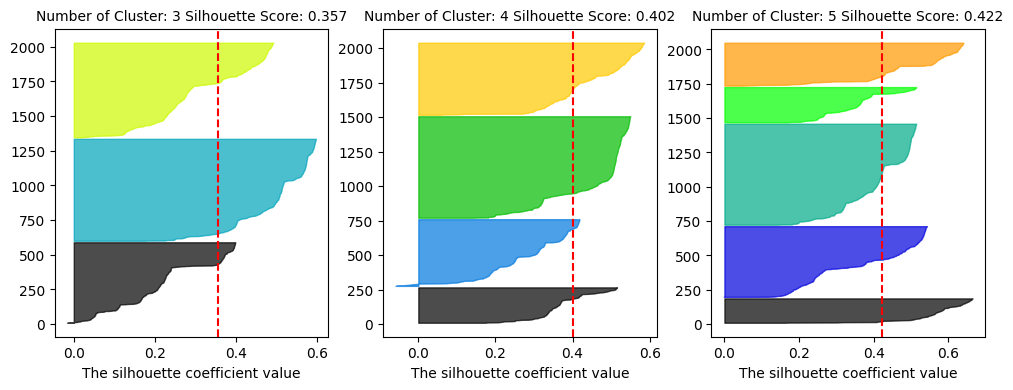

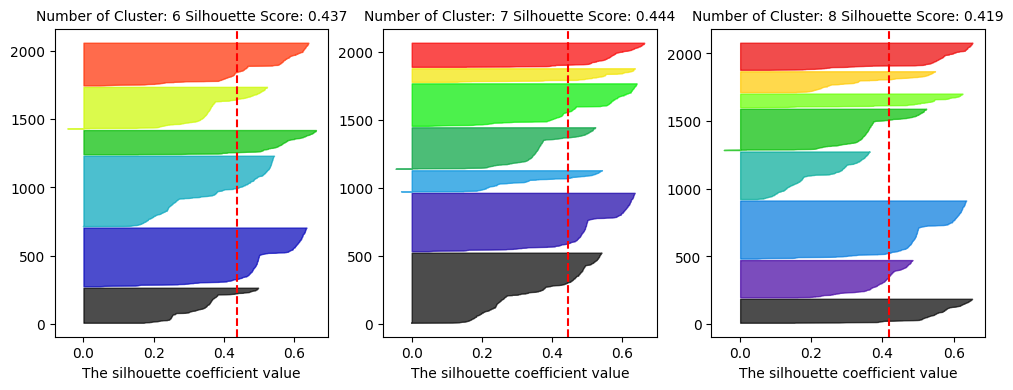

In [ ]:
visualize_silhouette('KMeans', [3,4,5], df_normalized)
visualize_silhouette('KMeans', [6,7,8], df_normalized)

In [ ]:
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans_labels = kmeans.fit_predict(df_normalized)
df['clusters'] = kmeans_labels
df

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,clusters
0,0,0,67,2,124670,1,2,0
1,1,1,22,1,150773,1,2,3
2,0,0,49,1,89210,0,0,4
3,0,0,45,1,171565,1,1,0
4,0,0,53,1,149031,1,1,0
...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,6
1996,1,1,27,1,117744,1,0,1
1997,0,0,31,0,86400,0,0,4
1998,1,1,24,1,97968,0,0,1


In [ ]:
# Principle Component Analysis (PCA)
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(df_normalized)

df['x'] = pca_transformed[:, 0]
df['y'] = pca_transformed[:, 1]

In [ ]:
def visualize_clusters(model, model_labels):

    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=df["x"], y=df["y"], hue=model_labels)

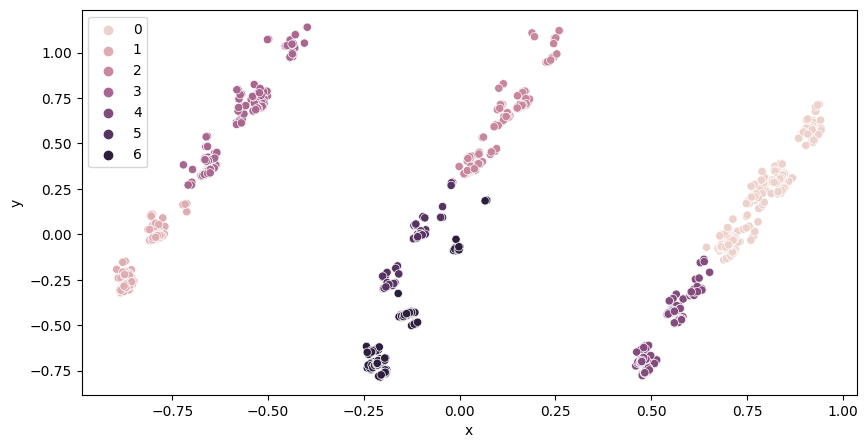

In [ ]:
visualize_clusters('K-means', kmeans_labels)

In [ ]:
# Visualize each Cluster
def visualize_categorical_vars(df):

    sex_counts = df['Sex'].value_counts().sort_values(ascending=True)
    marital_counts = df['Marital status'].value_counts().sort_values(ascending=True)
    education_counts = df['Education'].value_counts().sort_values(ascending=True)
    occupation_counts = df['Occupation'].value_counts().sort_values(ascending=True)
    settlement_counts = df['Settlement size'].value_counts().sort_values(ascending=True)
    categorical_lst = [sex_counts, marital_counts, education_counts, occupation_counts, settlement_counts]
    categorical_labels = ['Sex', 'Marital Status', 'Education', 'Occupation', 'Settlement Size']

    row_n=3
    col_n=2

    fig = make_subplots(rows=row_n, cols=col_n)

    for i, col in enumerate(categorical_labels):
        fig.add_trace(
            go.Bar(
                x=categorical_lst[i].index.astype('str'),
                y=categorical_lst[i].values,
                name=col,
                text=np.round(categorical_lst[i].values,3),
                textposition='inside',
                marker_color=px.colors.sequential.Emrld,
                textfont=dict(size=10)),
            row=int(i/col_n)+1, col=int(i%col_n)+1
            )

    fig.update_layout(
        height=800,
        title_text="Categorical Variable Distribution",
        template='simple_white')
    fig.update_traces(marker_line_color='black',
                      marker_line_width=1.5,
                      opacity=0.8)
    fig.show()

def visualize_continuous_vars(df):
    fig = make_subplots(rows=2, cols=2)

    fig.add_trace(
        go.Histogram(x=df['Age'], name='Age Histogram', marker_color='darkgreen'),
        row=1, col=1
    )
    fig.add_trace(
        go.Box(y=df['Age'], name='Age Box Plot', marker_color='darkgreen'),
        row=1, col=2
    )


    fig.add_trace(
        go.Histogram(x=df['Income'], name='Income Histogram', marker_color='seagreen'),
        row=2, col=1
    )

    fig.add_trace(
        go.Box(y=df['Income'], name='Income Box Plot', marker_color='seagreen'),
        row=2, col=2
    )

    fig.update_layout(
        title_text='Continuous Variable Distribution',
        template='simple_white')
    fig.update_traces(
        marker_line_color='black',
        marker_line_width=1.5,
        opacity=0.8)
    fig.show()

In [ ]:
cluster_zero = df.loc[df['clusters']==6]
cluster_zero = decode_df(cluster_zero)
visualize_categorical_vars(cluster_zero)
visualize_continuous_vars(cluster_zero)

**Mean Shift clustering**

In [ ]:
# Find best bandwidth for perform the mean-shift clustering
best_bandwidth = estimate_bandwidth(df_normalized, quantile=0.15)
print('Best Bandwidth: ', round(best_bandwidth, 3))

Best Bandwidth:  0.742


In [ ]:
meanshift = MeanShift(bandwidth=best_bandwidth)
meanshift_labels = meanshift.fit_predict(df_normalized)
print('MeanShift Labels Type: ', np.unique(meanshift_labels))

df['meanshift_labels'] = meanshift_labels
df

MeanShift Labels Type:  [0 1 2 3]


,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,clusters,x,y,meanshift_labels
0,0,0,67,2,124670,1,2,0,0.826086,0.354652,0
1,1,1,22,1,150773,1,2,3,-0.524891,0.716293,1
2,0,0,49,1,89210,0,0,4,0.486009,-0.690668,0
3,0,0,45,1,171565,1,1,0,0.707351,-0.028668,0
4,0,0,53,1,149031,1,1,0,0.712574,-0.037939,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,6,-0.195388,-0.680837,3
1996,1,1,27,1,117744,1,0,1,-0.793264,-0.016224,1
1997,0,0,31,0,86400,0,0,4,0.494899,-0.746080,0
1998,1,1,24,1,97968,0,0,1,-0.875828,-0.285273,1


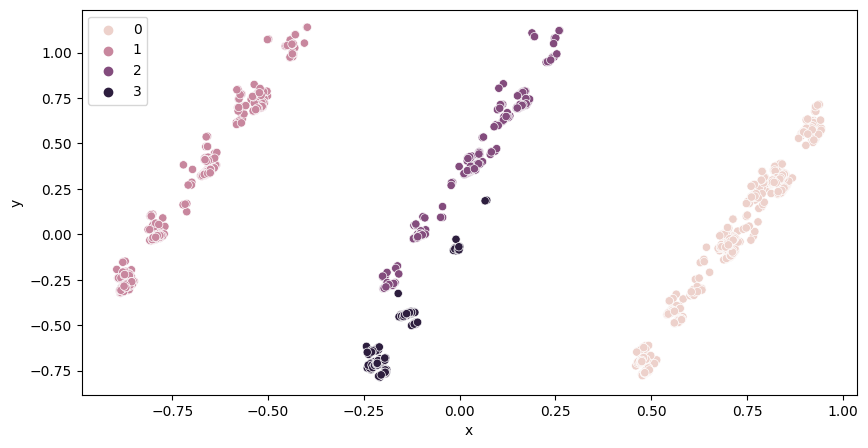

In [ ]:
visualize_clusters('Mean-Shift', meanshift_labels)

In [ ]:
cluster_zero = df.loc[df['meanshift_labels']==3]
cluster_zero = decode_df(cluster_zero)
visualize_categorical_vars(cluster_zero)
visualize_continuous_vars(cluster_zero)

**Gaussian Mixture clustering**

In [ ]:
# Find the best K cluster for gaussian mixture

def try_clustering_K(K, data):
  cluster_values = list(range(1, K+1))
  likelihoods = []

  for c in cluster_values:
    model = GaussianMixture(n_components=c, random_state=0)
    model.fit(data)
    likelihoods.append(model.score(data))

  return likelihoods

In [ ]:
output = try_clustering_K(12, df_normalized)
distance = pd.DataFrame({"clusters": list(range(1, 13)), "sum of squared distance": output})
distance

,clusters,sum of squared distance
0,1,0.181974
1,2,5.264633
2,3,8.719295
3,4,10.926877
4,5,13.622982
5,6,15.094988
6,7,15.347198
7,8,16.537355
8,9,17.042731
9,10,17.344226


In [ ]:
plot_graph("clusters", "sum of squared distance", distance)

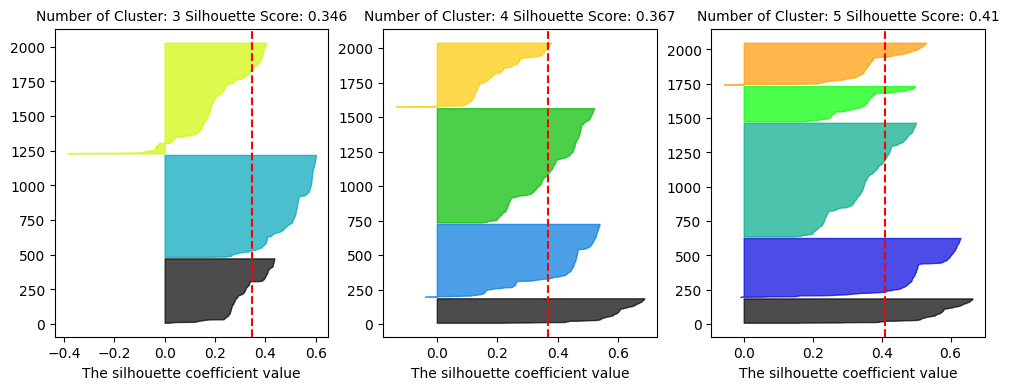

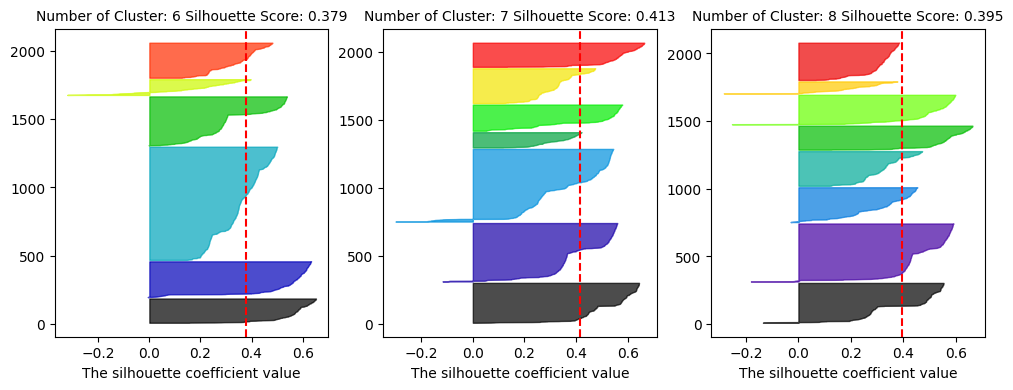

In [ ]:
visualize_silhouette('GMM', [3,4,5], df_normalized)
visualize_silhouette('GMM', [6,7,8], df_normalized)

In [ ]:
gmt = GaussianMixture(n_components=7, random_state=0)
gmt_labels = gmt.fit_predict(df_normalized)
df['GMT Cluster'] = gmt_labels
df

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,clusters,x,y,meanshift_labels,GMT Cluster
0,0,0,67,2,124670,1,2,0,0.826086,0.354652,0,2
1,1,1,22,1,150773,1,2,3,-0.524891,0.716293,1,3
2,0,0,49,1,89210,0,0,4,0.486009,-0.690668,0,0
3,0,0,45,1,171565,1,1,0,0.707351,-0.028668,0,2
4,0,0,53,1,149031,1,1,0,0.712574,-0.037939,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,6,-0.195388,-0.680837,3,6
1996,1,1,27,1,117744,1,0,1,-0.793264,-0.016224,1,1
1997,0,0,31,0,86400,0,0,4,0.494899,-0.746080,0,0
1998,1,1,24,1,97968,0,0,1,-0.875828,-0.285273,1,1


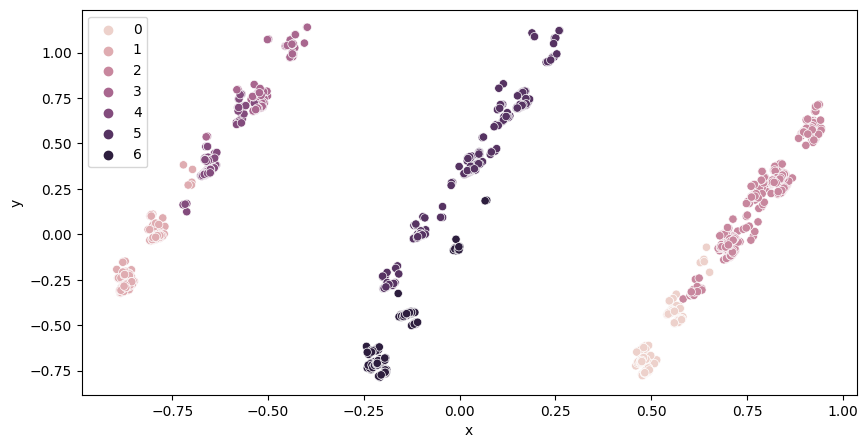

In [ ]:
visualize_clusters('GMT', gmt_labels)

In [ ]:
cluster_zero = df.loc[df['GMT Cluster']==6]
cluster_zero = decode_df(cluster_zero)
visualize_categorical_vars(cluster_zero)
visualize_continuous_vars(cluster_zero)

In [ ]:
# Evaluate model

models = [df['clusters'], df['meanshift_labels'], df['GMT Cluster']]

scores = [evaluate(model) for model in models]

label_model = ['KMeans', 'MeanShift', "Gaussian Mixture"]

In [ ]:
# Plot each model with its corresponding evaluate score

model_evaluate = pd.Series(scores, index=label_model, name='scores').sort_values(ascending=True)

fig = px.bar(x=model_evaluate.index, y=model_evaluate.values,
             text=np.round(model_evaluate.values,5),
             color=model_evaluate.values,
             color_continuous_scale='YlGn')

fig.update_traces(marker_line_color='black',
                  marker_line_width=1.5,
                  opacity=0.8)
fig.update_layout(
    title_text='Modelling',
    xaxis=dict(
        title='Model',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Average Silhouette Score',
        titlefont_size=16
    ),
    template='simple_white',
)
fig.show()